In [123]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

In [8]:
# Collect archived beachie creek fire perimeters
# https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Archived_Wildfire_Perimeters2/FeatureServer/0/query?where=IncidentName%20%3D%20%27BEACHIE%20CREEK%27&outFields=*&outSR=4326&f=geojson

beachie_perimeters = gpd.read_file('fire_perimeters/beachie_archives_09_22.geojson')

In [9]:
# Collect ownership layers (vectorized in QGIS)
# https://www.fs.usda.gov/rds/archive/Catalog/RDS-2020-0044

tribal = gpd.read_file('ownerships/tribal_dissolved.geojson')
federal = gpd.read_file('ownerships/federal_dissolved.geojson')
state = gpd.read_file('ownerships/state_dissolved.geojson')
local = gpd.read_file('ownerships/local_dissolved.geojson')
corporate = gpd.read_file('ownerships/corporate_dissolved.geojson')
timo = gpd.read_file('ownerships/timo_reit_dissolved.geojson')
private = gpd.read_file('ownerships/private_other_dissolved.geojson')

# Collect USFS "Timber Production Primary Emphasis" land suitability class
# https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_TimberHarvest_01/MapServer/8/query?where=ADMIN_FOREST_CODE%20%3D%20%2706%27%20AND%20ADMIN_REGION_CODE%20%3D%20%2706%27%20AND%20LAND_SUITABILITY_CLASS_CODE%20%3D%20%27500%27&outFields=*&outSR=4326&f=geojson
usfs_files = ['ownerships/hood_2.geojson', 'ownerships/willamette_1.geojson', 'ownerships/willamette_2.geojson', 'ownerships/willamette_3.geojson', 'ownerships/willamette_4.geojson', 'ownerships/willamette_5.geojson', 'ownerships/willamette_6.geojson']
usfs_timber = gpd.read_file('ownerships/hood_1.geojson')
for usfs_file in usfs_files:
    usfs_timber = usfs_timber.append(gpd.read_file(usfs_file))
    
ownerships = { 'tribal': tribal, 'federal': federal, 'state': state, 'local': local, 'corporate': corporate,
               'timo': timo, 'private': private , 'usfs_timber': usfs_timber}

In [10]:
# Find intersections of fire area and each ownership area
# this takes a while

intersections = {}

for key in ownerships:
    intersection = {}
    for i in range(len(beachie_perimeters)):
        perimeter_date = beachie_perimeters.iloc[i].GDB_TO_DATE
        perimeter = gpd.GeoDataFrame({'geometry': [beachie_perimeters.iloc[i].geometry]})
        intersection[perimeter_date] = gpd.overlay(perimeter, ownerships[key], how='intersection')
    
    intersections[key] = intersection
    print(f'{key} done')

tribal done
federal done
state done
local done
corporate done
timo done
private done
usfs_timber done


In [146]:
# Save interesctions
pickle.dump(intersections, open("intersections.p", "wb"))

In [148]:
# Find areas of intersection in meters squared
# this takes a while

proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

intersection_areas = {}
for ownership in ownerships:
    ownership_area = {}
    for time in beachie_perimeters.GDB_TO_DATE:
        projected_area = 0
        for geo in intersections[ownership][time].geometry:
            projected_area += transform(proj, geo).area
        ownership_area[time] = projected_area
    intersection_areas[ownership] = ownership_area
    print(f'{ownership} done')

tribal done
federal done
state done
local done
corporate done
timo done
private done
usfs_timber done


In [149]:
# Save intersection areas
pickle.dump(intersection_areas, open("intersection_areas.p", "wb"))

In [152]:
# Convert intersection areas from meters squared to acres
intersection_areas_acres = intersection_areas
for ownership in ownerships:
    for time in beachie_perimeters.GDB_TO_DATE:
        intersection_areas_acres[ownership][time] *= 0.000247105

In [154]:
# Tally timber, non-timber acres
timber_acres = []
non_timber_acres = []
for time in beachie_perimeters.GDB_TO_DATE:
    non_timber_acres.append(intersection_areas['federal'][time] - intersection_areas['usfs_timber'][time])
    timber_acres.append(intersection_areas['usfs_timber'][time] + intersection_areas['state'][time] + intersection_areas['private'][time] + intersection_areas['corporate'][time] + intersection_areas['timo'][time])

In [220]:
# Linear interpolate for animation
times = np.linspace(beachie_perimeters.iloc[0].GDB_TO_DATE, beachie_perimeters.iloc[-4].GDB_TO_DATE, 800)
non_timber_acres_anim = []
timber_acres_anim = []
for time in times:
    non_timber_acres_anim.append(np.interp(time, beachie_perimeters.GDB_TO_DATE, non_timber_acres))
    timber_acres_anim.append(np.interp(time, beachie_perimeters.GDB_TO_DATE, timber_acres))

In [ ]:
# Create animated plot
plt.figure()
xmin, ymin, xmax, ymax = beachie_perimeters.iloc[-1].geometry.bounds

for n in range(len(times) - 1):
    plt.cla()
    fig, axes = plt.subplots(3,1, figsize=(15, 15))
    
    i = 1
    time = times[0]
    while beachie_perimeters.iloc[i-1].GDB_TO_DATE < times[n]:
        time = beachie_perimeters.iloc[i].GDB_TO_DATE
        i += 1
    
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(ymin, ymax)
    axes[0].get_xaxis().set_ticks([])
    axes[0].get_yaxis().set_ticks([])
    intersections['federal'][time].plot(ax=axes[0], color='b')
    intersections['usfs_timber'][time].plot(ax=axes[0], color='r')
    intersections['private'][time].plot(ax=axes[0], color='r')
    intersections['corporate'][time].plot(ax=axes[0], color='r')
    intersections['timo'][time].plot(ax=axes[0], color='r')
    intersections['state'][time].plot(ax=axes[0], color='r')
    

    axes[1].plot(times[:n], non_timber_acres_anim[:n], color='b')
    axes[1].plot(times[:n], timber_acres_anim[:n], color='r')
    
    axes[2].pie([timber_acres_anim[n], non_timber_acres_anim[n]], labels=['Timber', 'Non-Timber'], colors=['r', 'b'])
    
    fig.suptitle(datetime.fromtimestamp(times[n]/1000, timezone.utc).strftime("%m/%d/%Y, %H:%M"), fontsize='xx-large')
    plt.savefig('frames/rame%03d.png' %n)

/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The G

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are atte

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have be

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/ian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, s

NameError: name 'x' is not defined

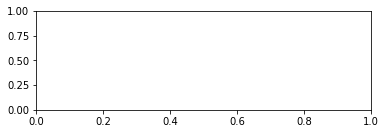

In [ ]:
# Plot acres burned per category
latest_time = beachie_perimeters.iloc[4].GDB_TO_DATE

labels = list(ownerships.keys())
acres = []
for label in labels:
    acres.append(np.sum(intersections[label][latest_time].area))
    
# Correct double counting of USFS timber land
acres[1] -= acres[-1]

acres = np.asarray(acres)
acres = acres / np.sqrt(np.sum(acres**2))
plt.pie(acres, labels=labels)
plt.show()

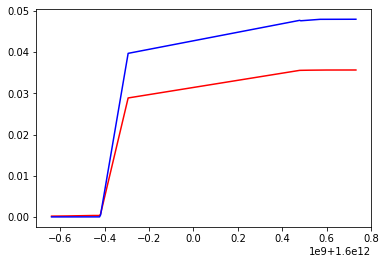

In [118]:
times = np.linspace(beachie_perimeters.iloc[0].GDB_TO_DATE, beachie_perimeters.iloc[-1].GDB_TO_DATE, 300)
non_t_acres = []
t_acres = []
for time in times:
    non_t_acres.append(np.interp(time, beachie_perimeters.GDB_TO_DATE, non_timber_acres))
    t_acres.append(np.interp(time, beachie_perimeters.GDB_TO_DATE, timber_acres))

plt.figure()
for n in range(len(times)):
    plt.cla()
    plt.plot(times[:n], non_t_acres[:n], color='b')
    plt.plot(times[:n], t_acres[:n], color='r')
    plt.savefig('frames/rame%03d.png' %n)

# plt.plot(beachie_perimeters.GDB_TO_DATE, non_timber_acres)
# plt.show()

712272540.0585859


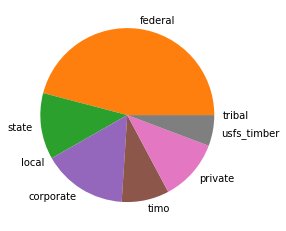

In [75]:
# Plot acres burned per category
latest_time = beachie_perimeters.iloc[9].GDB_TO_DATE

labels = list(ownerships.keys())
acres = []
for label in labels:
    acres.append(np.sum(intersections[label][latest_time].area))

acres = np.asarray(acres)
acres = acres / np.sqrt(np.sum(acres**2))
plt.pie(acres, labels=labels)
plt.show()

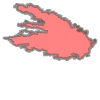

In [90]:
beachie_perimeters.iloc[-1].geometry

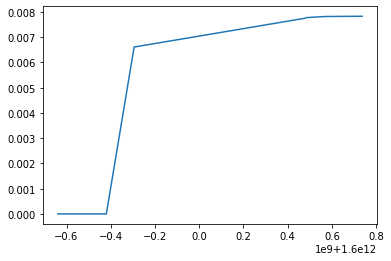

In [40]:
times = []
ars = []
for item in intersections['timo'].items():
    times.append(item[0])
    ars.append(np.sum(item[1].area))

plt.plot(times, ars)
plt.show()

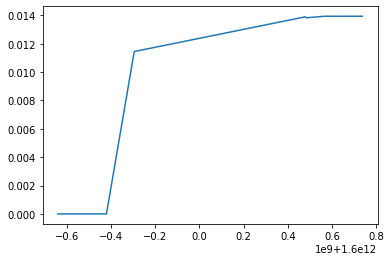

In [42]:
times = []
ars = []
for item in intersections['corporate'].items():
    times.append(item[0])
    ars.append(np.sum(item[1].area))

plt.plot(times, ars)
plt.show()

In [87]:
perimeter = beachie_perimeters.iloc[-1]
perimeter_date = perimeter.GDB_FROM_DATE
for key in ownerships:
    intersection_area = 0
    for j in range(len(intersections[key])):
        intersection = intersections[key].iloc[j]
        if  intersection.GDB_FROM_DATE == perimeter.GDB_FROM_DATE:
            print(intersection.GDB_FROM_DATE)
#            intersection_area += intersection.geometry.area
    
#     perimeter_area = perimeter.geometry.area
#     perimeter_date_readable = datetime.fromtimestamp(beachie_perimeters.iloc[i].CreateDate/1000, timezone.utc)
#     print(perimeter_date_readable, key, intersection_area/perimeter_area)
# # 

In [79]:
# Find intersection areas relative to total fire area
for i in range(len(beachie_perimeters)):
    perimeter = beachie_perimeters.iloc[i]
    perimeter_date = perimeter.GDB_FROM_DATE  # using GDB_FROM_DATE as UID for perimeter (!!!)
    intersection_area = 0
    for key in ownerships:
        for j in range(len(intersections[key])):
            intersection = intersections[key].iloc[j]
            if perimeter_date == intersection.GDB_FROM_DATE:
                intersection_area += intersection.geometry.area
    
    perimeter_area = perimeter.geometry.area
    perimeter_date_readable = datetime.fromtimestamp(beachie_perimeters.iloc[i].CreateDate/1000, timezone.utc)
    print(perimeter_date_readable, key, intersection_area/perimeter_area)
# 
# for i in range(len(beachie_perimeters)):
#     perimeter = beachie_perimeters.iloc[i]
#     
    
#     for 
#     for key in ownerships:
#         print(intersections[key])
#         area = intersections[key].iloc[0].geometry.area
#         print(key, area)

2020-08-16 20:20:57+00:00 usfs_timber 1.0
2020-09-06 12:40:00+00:00 usfs_timber 1.0
2020-09-06 14:19:47+00:00 usfs_timber 1.023498699574146
2020-09-08 15:11:06+00:00 usfs_timber 1.023531900001113
2020-09-08 15:11:06+00:00 usfs_timber 0.9977246410574586
2020-09-15 12:44:07+00:00 usfs_timber 0.0


In [141]:
print(beachie_perimeters.iloc[0].GDB_TO_DATE)

1599360593000.0


In [89]:
    
# # for i in range(len(beachie_perimeters)):
# #     perimeter = beachie_perimeters.iloc[i]
# #     relative_areas = {}
# #     perimeter_area = perimeter.geometry.area
# #     print(type(perimeter.geometry))
# # #     for key in ownerships:
# #         intersection = gpd.overlay(perimeter_gdf, ownerships[key], how='intersection')
# #         intersection_area = 0
# #         for area in res_intersection.area:
# #             intersection_area += area
# #         relative_areas[key] = intersection_area
    
# #     relative_areas_histories[perimeter['CreateDate']] = relative_areas
    
# for key in ownerships:
#     intersection = gpd.overlay(beachie_perimeters, ownerships[key], how='intersection')
# #         intersection_area = 0
# #         for area in res_intersection.area:
# #             intersection_area += area
# #         relative_areas[key] = intersection_area
# for i in range(len(beachie_perimeters)):
#     perimeter = beachie_perimeters.iloc[i]
#     print(perimeter.geometry.area)

0.00018812596415271535
0.00019560112727239236
0.0003571051348154305
0.00035660135091090755
0.07321462528812639
0.08792826364396107


In [81]:
print(intersections['federal'])

   OBJECTID  Shape__Area  Shape__Length  GDB_ARCHIVE_OID   IncidentName  \
0   89363.0     0.000188       0.073008         190026.0  Beachie Creek   
1   89384.0     0.000196       0.081086         190148.0  Beachie Creek   
2   89557.0     0.000357       0.163597         190709.0  Beachie Creek   
3   89598.0     0.000357       0.160355         190856.0  Beachie Creek   
4   89697.0     0.073215       3.467286         191108.0  Beachie Creek   
5       NaN          NaN            NaN              NaN  Beachie Creek   

                 FeatureCategory       MapMethod  \
0  Wildfire Daily Fire Perimeter  Infrared Image   
1  Wildfire Daily Fire Perimeter  Infrared Image   
2  Wildfire Daily Fire Perimeter  Infrared Image   
3  Wildfire Daily Fire Perimeter  Infrared Image   
4  Wildfire Daily Fire Perimeter  Infrared Image   
5                            NaN             NaN   

                               Comments       GISAcres DeleteThis  ...  \
0                                  

In [137]:
print(beachie_perimeters)

   OBJECTID  Shape__Area  Shape__Length  GDB_ARCHIVE_OID   IncidentName  \
0     89363     0.000188       0.073008         190026.0  Beachie Creek   
1     89384     0.000196       0.081086         190148.0  Beachie Creek   
2     89557     0.000357       0.163597         190709.0  Beachie Creek   
3     89598     0.000357       0.160355         190856.0  Beachie Creek   
4     89697     0.073215       3.467286         191108.0  Beachie Creek   
0     95731     0.088096       5.842455              NaN  Beachie Creek   

                 FeatureCategory       MapMethod  \
0  Wildfire Daily Fire Perimeter  Infrared Image   
1  Wildfire Daily Fire Perimeter  Infrared Image   
2  Wildfire Daily Fire Perimeter  Infrared Image   
3  Wildfire Daily Fire Perimeter  Infrared Image   
4  Wildfire Daily Fire Perimeter  Infrared Image   
0  Wildfire Daily Fire Perimeter  Infrared Image   

                               Comments       GISAcres DeleteThis  ... UnitID  \
0                           

1599351590000.0
1599396000000.0
1599524390000.0
1599577866000.0
1599683937000.0


In [132]:
# Values for current beachie
# fed_intersection = intersections['federal'].iloc[-1]
# state_intersection = intersections['state'].iloc[-1]
# private_intersection = intersections['private'].iloc[-1]
# timo_intersection = intersections['timo'].iloc[-1]
# corporate_intersection = intersections['corporate'].iloc[-1]
# usfs_timber_intersection = intersections['usfs_timber'].iloc[-1]

perimeter_area = beachie_perimeters.iloc[-1].geometry.area

fed_intersection_area = intersections['federal'].iloc[-1].geometry.area /  beachie_perimeters.iloc[-1].geometry.area
state_intersection_area = intersections['state'].iloc[-1].geometry.area /  beachie_perimeters.iloc[-1].geometry.area
private_intersection_area = intersections['private'].iloc[-1].geometry.area /  beachie_perimeters.iloc[-1].geometry.area
timo_intersection_area = intersections['timo'].iloc[-1].geometry.area /  beachie_perimeters.iloc[-1].geometry.area
corporate_intersection_area = intersections['corporate'].iloc[-1].geometry.area / beachie_perimeters.iloc[-1].geometry.area
# usfs_timber_intersection_area = intersections['usfs_timber'].area / beachie_perimeters.iloc[-1].geometry.area

usfs_timber_intersection_area = 0
for i in range(len(intersections['usfs_timber'])):
    intersection = intersections['usfs_timber'].iloc[i]
    if np.isnan(intersection.OBJECTID_1):
        usfs_timber_intersection_area += intersection.geometry.area / beachie_perimeters.iloc[-1].geometry.area

print(datetime.fromtimestamp(beachie_perimeters.iloc[-1].CreateDate/1000, timezone.utc))
        
print(fed_intersection_area, state_intersection_area, private_intersection_area, timo_intersection_area, corporate_intersection_area, usfs_timber_intersection_area)

print(private_intersection_area + timo_intersection_area + corporate_intersection_area + usfs_timber_intersection_area)
# for i in range(len(beachie_perimeters)):
#     perimeter = beachie_perimeters.iloc[i]
#     perimeter_date = perimeter.GDB_FROM_DATE  # using GDB_FROM_DATE as UID for perimeter (!!!)
#     intersection_area = 0
#     for key in ownerships:
#         for j in range(len(intersections[key])):
#             intersection = intersections[key].iloc[j]
#             if perimeter_date == intersection.GDB_FROM_DATE:
#                 intersection_area += intersection.geometry.area
    
#     perimeter_area = perimeter.geometry.area
#     perimeter_date_readable = datetime.fromtimestamp(beachie_perimeters.iloc[i].CreateDate/1000, timezone.utc)
#     print(perimeter_date_readable, key, intersection_area/perimeter_area)

2020-09-15 12:44:07+00:00
0.4585539437516996 0.12168317769914719 0.11538428903441199 0.08763245729435552 0.15729219111759887 0.057522148284865245
0.4178310857312316


1.0 47.65557852585013 43.63547327555664 35.14931909110266 60.86760373799969 0.057522148284865245
139.70991825294385


In [129]:
print(intersections['federal'].iloc[0].GDB_FROM_DATE)
print(intersections['state'].iloc[0].GDB_FROM_DATE)
print(intersections['private'].iloc[0].GDB_FROM_DATE)
print(intersections['timo'].iloc[0].GDB_FROM_DATE)
print(intersections['corporate'].iloc[0].GDB_FROM_DATE)
print(intersections['usfs_timber'].iloc[0].GDB_FROM_DATE)

1599351590000.0
1599683937000.0
1599683937000.0
1599683937000.0
1599683937000.0
1599524390000.0


In [174]:
print(datetime.fromtimestamp(beachie_perimeters.iloc[i].CreateDate/1000, timezone.utc).strftime("%m/%d/%Y, %H:%M"))

09/21/2020, 12:16
